# Reinforcement Learning for Cart Pole game

Import libraries:

In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
% matplotlib notebook

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Defining hyperparameters:

In [2]:
num_episodes = 300      # Number of episodes for training
learning_rate = 0.01
gamma = 0.99           # Discount factor for reward
num_Hidden = 200       # number of nodes in the hidden layer

env = gym.make('CartPole-v0')    # Choose a game and create an environment
obs_dim = env.reset().shape      # obervation dimension
num_actions = env.action_space.n # number of actions (this works only for descrete action space, which is the case here)

### Define functions

In [3]:
def discount_rewards(r):
    '''Takes a 1D rewards (one episode) and discounts it and also standardize
    the rewards to be unit normal (helps control the gradient estimator variance)'''
    
    # Discounting
    dis_r = np.zeros_like(r)
    running_sum = 0
    for t in reversed(range(len(r))):
        running_sum = gamma*running_sum + r[t]
        dis_r[t] = running_sum
    
    # Normailzing
    dis_r = (dis_r - np.mean(dis_r))/np.std(dis_r)
        
    return dis_r

### Build model

We start by creating the simplest model: Observation as an input, one hidden layer and two nodes in the output layer - corresponding to the action of moving right (1) or left (0).

To keep order in our model, we use name scopes which basically group the layers of our model in a simple to follow way. Eventually, when using [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) for visualizing the model, the graph is more readable and makes it easy to understand the model and find errors.

In [4]:
'''Create placeholders for inputs'''
# A place holder for input observations
input_ = tf.placeholder(tf.float32, shape = (None, obs_dim[0]), name = "input")
# A place holder for actions in a full episode
actions = tf.placeholder(tf.float32, shape = (None, num_actions), name = "actions")
# A place holder for discounted rewards in a full episode
dis_rewards = tf.placeholder(tf.float32, shape = (None, ), name = "dis_rewards")

'''Fully connected layers'''
with tf.name_scope("FC1"):
    fc1 = tf.layers.dense(inputs = input_, units = num_Hidden ,activation = tf.nn.relu, name = "fc1" )

with tf.name_scope("FC2"):
    fc2 = tf.layers.dense(inputs = fc1, units = num_actions ,activation = None, name = "fc2" )

with tf.name_scope("Action_PDF"):
    # Operate with softmax on fc2 outputs to get an action probability distribution
    action_prob_dist = tf.nn.softmax(logits = fc2, name = "softamx")

with tf.name_scope("Loss"):
    '''Define loss'''
    # Fist define reular softmax cross entropy loss
    CE_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = actions, logits = fc2, name = "CE_loss")
    # Modulate the loss based on our discounted reward - this is where reinforcment learning happens,
    # we favor actions that produced high reward
    loss = tf.reduce_mean(CE_loss * dis_rewards)

with tf.name_scope("Training"):
    '''Define optimizer'''
    training_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

'''Define saver for saving and restoring model'''
saver = tf.train.Saver()

Define a writer for saving summaries to TensorBoard:

In [5]:
# writer = tf.summary.FileWriter("./tensorboard/1/")

Here is an example of a graph visualization:

<img src="./img/model_graph.png" width="500">

Each block in the graph is expandable and let you see the content inside, for example see an [image](./img/model_graph_loss.png) with expanded loss block.

### Train model

Now that we have a model ready, we can start training it.

Our goal is to achieve a model that uses the current observation to create the best probability distribution function (PDF) for the next action to be taken. This is **not a deterministic model** - the agent has a fine probability to take any action after receiving an observation, with larger probability to take favorable actions.

To achieve that, in each step, we use our model to generate a PDF of actions, draw an action out of it and take the next step.
When we reach the end of the episode, we compute the episode loss by feeding the observation, action and discounted rewards vectors (which we kept track of). Our optimizer minimizes the loss which makes favorable (unfavorable) actions more probable (less probable) due to the multiplicative factor of the discounted reward. By repeating these steps to each episode, our agent gradually improves its PDF and becomes a better player!

In [6]:
ep_action, ep_obs, ep_reward = [], [], []  # Allocate space for episode actions, observations and rewards
tot_ep_reward = [] # Total episode reward
mean_reward = []

''' Run TF session '''
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    ''' Run episodes '''
    for ep in range(num_episodes): 
        obs = env.reset()  # Reset and save first observation
        ep_obs.append(obs) # append observation

        ''' Run steps '''
        while True:
            # Propagate forward to compute action probability distribution
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict = {input_ : obs.reshape((1,4))}))
            action = np.random.choice(np.arange(num_actions), p = apd)   # Sample an action based on the pdf
            obs, reward, done, info = env.step(action)  # Take action and save observation, reward and done boolean
            
            # Convert action to one hot
            action_oh = np.zeros((1,num_actions))
            action_oh[0,action] = 1
            
            ep_action.append(action_oh)  # append action
            ep_obs.append(obs)           # append observation
            ep_reward.append(reward)     # append reward

            if done: 
                # Stack vertically episode parameters to one np.array
                ep_action = np.vstack(ep_action)
                ep_obs = np.vstack(ep_obs)
                ep_reward = np.hstack(ep_reward)

                # Discount rewards
                dis_rewards_arr = discount_rewards(ep_reward)
                # Compute loss and optimize
                sess.run([loss, training_opt],
                         feed_dict = {input_ : ep_obs[:-1], actions : ep_action, dis_rewards : dis_rewards_arr})
                
                tot_ep_reward.append(np.sum(ep_reward))  # Compute total reward for episode
                mean_reward.append(np.mean(tot_ep_reward))
                
                 # print info
                print("-------------------------------------------------")
                print("Episode {}".format(ep))
                print("Episode ended after {} steps".format(ep_action.shape[0]))
                print("Accumulated reward in this episode {}".format(tot_ep_reward[ep]))
                print("Mean reward so far {:0.2f}".format(np.mean(tot_ep_reward)))
                print("Maximal reward so far {}".format(np.max(tot_ep_reward)))
                
                ep_action, ep_obs, ep_reward = [], [], []  # Clear episode values for next episode
                      
                break

    saver.save(sess, "models/model.ckpt") # save model for later
#     writer.add_graph(sess.graph) # Save graph for displaying with TensorBoard
env.close()

-------------------------------------------------
Episode 0
Episode ended after 32 steps
Accumulated reward in this episode 32.0
Mean reward so far 32.00
Maximal reward so far 32.0
-------------------------------------------------
Episode 1
Episode ended after 14 steps
Accumulated reward in this episode 14.0
Mean reward so far 23.00
Maximal reward so far 32.0
-------------------------------------------------
Episode 2
Episode ended after 38 steps
Accumulated reward in this episode 38.0
Mean reward so far 28.00
Maximal reward so far 38.0
-------------------------------------------------
Episode 3
Episode ended after 28 steps
Accumulated reward in this episode 28.0
Mean reward so far 28.00
Maximal reward so far 38.0
-------------------------------------------------
Episode 4
Episode ended after 18 steps
Accumulated reward in this episode 18.0
Mean reward so far 26.00
Maximal reward so far 38.0
-------------------------------------------------
Episode 5
Episode ended after 14 steps
Accumu

-------------------------------------------------
Episode 45
Episode ended after 70 steps
Accumulated reward in this episode 70.0
Mean reward so far 45.15
Maximal reward so far 200.0
-------------------------------------------------
Episode 46
Episode ended after 48 steps
Accumulated reward in this episode 48.0
Mean reward so far 45.21
Maximal reward so far 200.0
-------------------------------------------------
Episode 47
Episode ended after 151 steps
Accumulated reward in this episode 151.0
Mean reward so far 47.42
Maximal reward so far 200.0
-------------------------------------------------
Episode 48
Episode ended after 85 steps
Accumulated reward in this episode 85.0
Mean reward so far 48.18
Maximal reward so far 200.0
-------------------------------------------------
Episode 49
Episode ended after 54 steps
Accumulated reward in this episode 54.0
Mean reward so far 48.30
Maximal reward so far 200.0
-------------------------------------------------
Episode 50
Episode ended after 14

-------------------------------------------------
Episode 94
Episode ended after 111 steps
Accumulated reward in this episode 111.0
Mean reward so far 84.45
Maximal reward so far 200.0
-------------------------------------------------
Episode 95
Episode ended after 91 steps
Accumulated reward in this episode 91.0
Mean reward so far 84.52
Maximal reward so far 200.0
-------------------------------------------------
Episode 96
Episode ended after 111 steps
Accumulated reward in this episode 111.0
Mean reward so far 84.79
Maximal reward so far 200.0
-------------------------------------------------
Episode 97
Episode ended after 111 steps
Accumulated reward in this episode 111.0
Mean reward so far 85.06
Maximal reward so far 200.0
-------------------------------------------------
Episode 98
Episode ended after 100 steps
Accumulated reward in this episode 100.0
Mean reward so far 85.21
Maximal reward so far 200.0
-------------------------------------------------
Episode 99
Episode ended af

-------------------------------------------------
Episode 139
Episode ended after 185 steps
Accumulated reward in this episode 185.0
Mean reward so far 90.99
Maximal reward so far 200.0
-------------------------------------------------
Episode 140
Episode ended after 156 steps
Accumulated reward in this episode 156.0
Mean reward so far 91.45
Maximal reward so far 200.0
-------------------------------------------------
Episode 141
Episode ended after 172 steps
Accumulated reward in this episode 172.0
Mean reward so far 92.02
Maximal reward so far 200.0
-------------------------------------------------
Episode 142
Episode ended after 175 steps
Accumulated reward in this episode 175.0
Mean reward so far 92.60
Maximal reward so far 200.0
-------------------------------------------------
Episode 143
Episode ended after 186 steps
Accumulated reward in this episode 186.0
Mean reward so far 93.25
Maximal reward so far 200.0
-------------------------------------------------
Episode 144
Episode 

-------------------------------------------------
Episode 184
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 115.48
Maximal reward so far 200.0
-------------------------------------------------
Episode 185
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 115.93
Maximal reward so far 200.0
-------------------------------------------------
Episode 186
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 116.38
Maximal reward so far 200.0
-------------------------------------------------
Episode 187
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 116.82
Maximal reward so far 200.0
-------------------------------------------------
Episode 188
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 117.26
Maximal reward so far 200.0
-------------------------------------------------
Episode 189
Epi

-------------------------------------------------
Episode 230
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 131.66
Maximal reward so far 200.0
-------------------------------------------------
Episode 231
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 131.95
Maximal reward so far 200.0
-------------------------------------------------
Episode 232
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 132.24
Maximal reward so far 200.0
-------------------------------------------------
Episode 233
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 132.53
Maximal reward so far 200.0
-------------------------------------------------
Episode 234
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 132.82
Maximal reward so far 200.0
-------------------------------------------------
Episode 235
Epi

-------------------------------------------------
Episode 275
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 142.80
Maximal reward so far 200.0
-------------------------------------------------
Episode 276
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 143.01
Maximal reward so far 200.0
-------------------------------------------------
Episode 277
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 143.21
Maximal reward so far 200.0
-------------------------------------------------
Episode 278
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 143.42
Maximal reward so far 200.0
-------------------------------------------------
Episode 279
Episode ended after 200 steps
Accumulated reward in this episode 200.0
Mean reward so far 143.62
Maximal reward so far 200.0
-------------------------------------------------
Episode 280
Epi

In order to get a sense of how good our model and to see if our agent improves in the training process, I like to plot the mean rewards gained in one episode over the episode number. This value would grow as our agent becomes more skilled and gains more rewards in each episode.

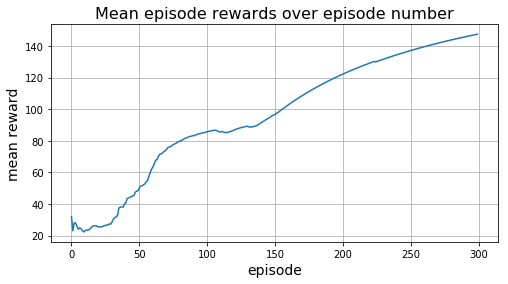

In [7]:
plt.figure(figsize=(8,4))
plt.plot(mean_reward)
plt.xlabel("episode", fontsize=14)
plt.ylabel("mean reward", fontsize = 14)
plt.title("Mean episode rewards over episode number", fontsize = 16)
plt.grid()

## Watch the agent play an episode

In [8]:
with tf.Session() as sess:
    saver.restore(sess, "models/model.ckpt") # load model
    obs = env.reset() # Reset env and save observation
    t = 0
    while True:
        env.render() # Render game
        # Use our model to create a probability distribution of actions based on observation
        apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,4))}))
        # Choose an action out of the PDF and take action
        action = np.random.choice(np.arange(num_actions), p = apd)
        obs, reward, done, info = env.step(action)
        t = t+1
        if done:
            print("Game ended after {} steps".format(t+1))
            break
env.close()

INFO:tensorflow:Restoring parameters from models/model.ckpt
Game ended after 201 steps
